In [ ]:
import pandas as pd 
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder


In [2]:
RAW_DATA_PATH = "../data/raw"
PROCESSED_DATA_PATH = "../data/processed"
RESULTS_DATA_PATH = "../data/results"


Reference for columns:
https://physionet.org/content/mimic-iv-ed/2.2/

### Helpers

In [3]:
def check_nulls(df):
	nulls = df.isnull().sum().sum()
	return nulls

def check_duplicates(df):
	duplicates = df.duplicated().sum().sum()
	return duplicates

def remove_nulls(df):
	# Remove rows with any null values
	cleaned_df = df.dropna()
	return cleaned_df

def remove_duplicates(df):
	# Remove duplicate rows
	cleaned_df = df.drop_duplicates()
	return cleaned_df

def preprocess_data(df, selected_columns):
    df = df[selected_columns]
	# Check for null values and duplicates
    nulls = check_nulls(df)
    duplicates = check_duplicates(df)

	# Remove nulls and duplicates
    df = remove_nulls(df)
    df = remove_duplicates(df)
    print(f"Null values removed: {nulls}, Duplicates removed: {duplicates}")
    return df

### 1- Diagnosis

In [4]:
diagnosed_path = os.path.join(RAW_DATA_PATH, "diagnosis.csv")
diagnosed_df = pd.read_csv(diagnosed_path)

| Column           | What it is (brief)                                                                                                                            |
| ---------------- | --------------------------------------------------------------------------------------------------------------------------------------------- |
| **subject\_id**  | An anonymized ID that uniquely identifies a patient across the entire MIMIC-IV database.                                                      |
| **stay\_id**     | The unique identifier for a single hospital stay (ICU or ward) for that patient. A patient can have multiple stay\_id values over time.       |
| **seq\_num**     | The position (1, 2, 3 …) of this diagnosis in the list coded for that stay. Lower numbers typically mark primary / earlier-entered diagnoses. |
| **icd\_code**    | The raw ICD (International Classification of Diseases) code assigned to the diagnosis (e.g., 431, R079).                                      |
| **icd\_version** | Indicates which ICD edition the code comes from—**9** for ICD-9-CM, **10** for ICD-10-CM.                                                     |
| **icd\_title**   | Plain-language description of the diagnosis corresponding to **icd\_code** (e.g., “INTRACEREBRAL HEMORRHAGE”).                                |


In [5]:
diagnosed_df.head()

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title
0,10025463,35470228,1,431,9,INTRACEREBRAL HEMORRHAGE
1,10027602,36678718,1,431,9,INTRACEREBRAL HEMORRHAGE
2,10009049,31628990,1,486,9,"PNEUMONIA,ORGANISM UNSPECIFIED"
3,10014078,38676365,1,3453,9,GRAND MAL STATUS
4,10007928,39661025,1,5780,9,HEMATEMESIS


<Axes: title={'center': 'Top 10 Most Common Sequence Numbers'}>

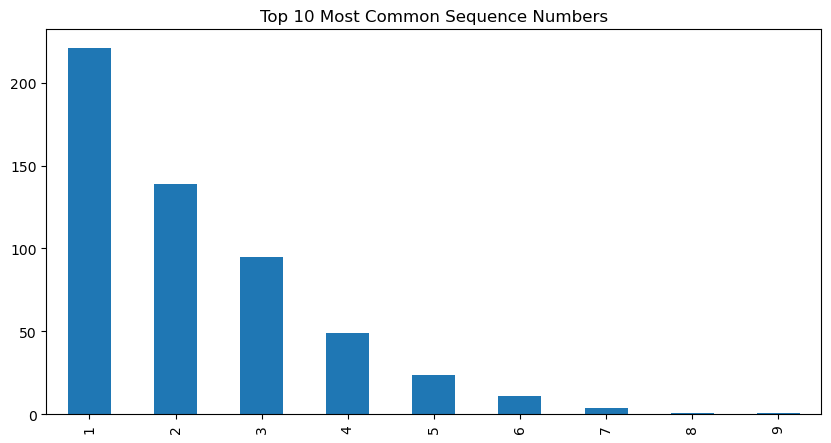

In [6]:
diagnosed_df['seq_num'].value_counts().head(10).plot(kind='bar', figsize=(10, 5), title='Top 10 Most Common Sequence Numbers')

In [7]:
diagnosed_columns = ['subject_id', 'stay_id', 'seq_num', 'icd_code', 'icd_version', 'icd_title']

In [8]:
diagnosed_df = preprocess_data(diagnosed_df, diagnosed_columns)

Null values removed: 0, Duplicates removed: 0


Text(0.5, 1.0, 'Top 10 Diagnoses by Count')

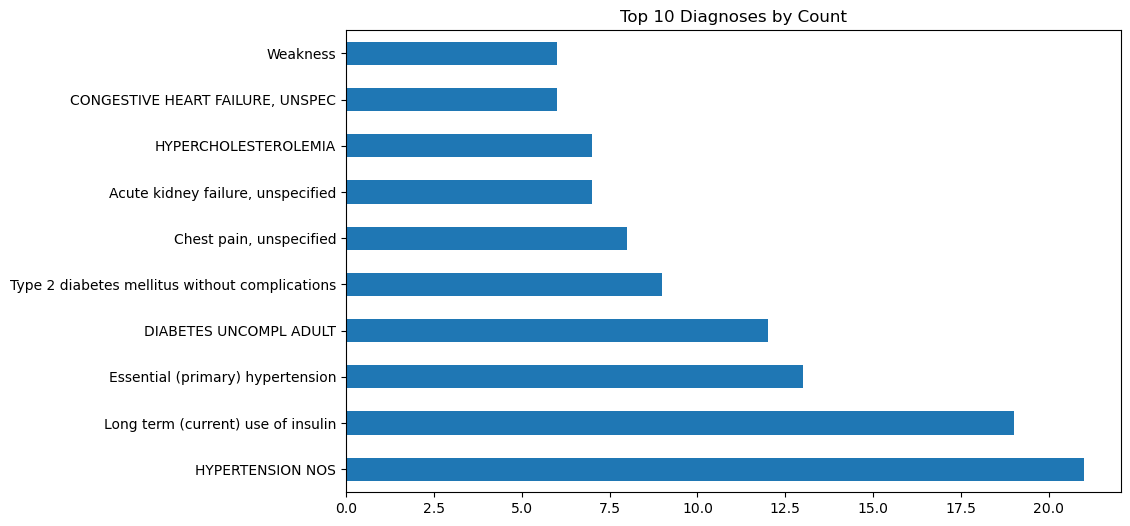

In [9]:
diagnosed_df['icd_title'].value_counts().head(10).plot(kind='barh', figsize=(10, 6));
plt.title('Top 10 Diagnoses by Count')

### 2- edstays (SELECTED)

| Column              | Description                                                                |
| ------------------- | -------------------------------------------------------------------------- |
| `subject_id`        | Unique identifier for a patient across all hospital stays.                 |
| `hadm_id`           | Hospital admission ID (null if not admitted to the hospital).              |
| `stay_id`           | Unique ID for the patient’s emergency department (ED) stay.                |
| `intime`            | Timestamp when the patient arrived in the ED.                              |
| `outtime`           | Timestamp when the patient left the ED (discharged or admitted).           |
| `gender`            | Patient gender (e.g., 'M', 'F').                                           |
| `race`              | Patient race or ethnicity (e.g., 'WHITE', 'BLACK/AFRICAN AMERICAN', etc.). |
| `arrival_transport` | How the patient arrived at the ED (e.g., 'AMBULANCE', 'WALK-IN').          |
| `disposition`       | Final ED outcome (e.g., 'ADMITTED', 'DISCHARGED', 'EXPIRED').              |


In [10]:
edstays_path = os.path.join(RAW_DATA_PATH, "edstays.csv")
edstays_df = pd.read_csv(edstays_path)
edstays_df.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition
0,10014729,23300884.0,37887480,2125-03-19 12:36:00,2125-03-19 16:59:47,F,WHITE - OTHER EUROPEAN,WALK IN,ADMITTED
1,10018328,26706939.0,34176810,2154-02-05 17:09:00,2154-02-05 22:54:00,F,WHITE,AMBULANCE,ADMITTED
2,10018328,NaN,32103106,2154-08-03 15:31:00,2154-08-03 22:29:00,F,WHITE,AMBULANCE,HOME
3,10020640,27984218.0,38797992,2153-02-12 21:59:00,2153-02-13 01:38:00,F,WHITE,AMBULANCE,ADMITTED
4,10015272,27993466.0,33473053,2137-06-12 16:54:00,2137-06-12 18:37:22,F,WHITE,AMBULANCE,ADMITTED


In [11]:
edstays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         222 non-null    int64  
 1   hadm_id            172 non-null    float64
 2   stay_id            222 non-null    int64  
 3   intime             222 non-null    object 
 4   outtime            222 non-null    object 
 5   gender             222 non-null    object 
 6   race               222 non-null    object 
 7   arrival_transport  222 non-null    object 
 8   disposition        222 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 15.7+ KB


We dont need columns like `intime` and `outtime` cause they have multi-collinearlity with the target variable `disposition`

In [12]:
edstays_columns = ["subject_id", 'stay_id', "gender", "race", "arrival_transport", "disposition"]

In [13]:
edstays_df[['disposition']].value_counts()

disposition                
ADMITTED                       150
HOME                            60
TRANSFER                         5
LEFT AGAINST MEDICAL ADVICE      2
LEFT WITHOUT BEING SEEN          2
OTHER                            2
ELOPED                           1
dtype: int64

In [14]:
edstays_df = edstays_df[edstays_df['disposition'].isin(["ADMITTED", "HOME"])]
edstays_df['disposition'].value_counts()

ADMITTED    150
HOME         60
Name: disposition, dtype: int64

In [15]:
edstays_df = preprocess_data(edstays_df, edstays_columns)

Null values removed: 0, Duplicates removed: 0


### 3- medrecon

In [16]:
medrecon_path = os.path.join(RAW_DATA_PATH, "medrecon.csv")
medrecon_df = pd.read_csv(medrecon_path)

| Column             | What it means (in simple terms)                                                                       |
| ------------------ | ----------------------------------------------------------------------------------------------------- |
| **subject\_id**    | The patient’s ID (unique for each person).                                                            |
| **stay\_id**       | The ID for this specific hospital or emergency department visit.                                      |
| **charttime**      | The date and time when the medication list was recorded.                                              |
| **name**           | The name of the medication the patient was taking before coming to the hospital.                      |
| **gsn**            | A code that represents the **generic form** of the drug (Generic Sequence Number).                    |
| **ndc**            | A unique identifier for the drug (National Drug Code). `0` means it’s missing.                        |
| **etc\_rn**        | A row number to distinguish multiple groups that a drug belongs to (e.g., Adderall shows up 3 times). |
| **etccode**        | A code representing the drug’s category/class (e.g., CNS stimulant).                                  |
| **etcdescription** | A short description of the drug’s group/class (e.g., "Attention Deficit-Hyperactivity Therapy").      |


In [17]:
medrecon_df.head()

,subject_id,stay_id,charttime,name,gsn,ndc,etc_rn,etccode,etcdescription
0,10023117,31283645,2171-11-07 20:38:00,*acuvite,0,0,1,NaN,NaN
1,10038999,34205403,2132-05-17 21:17:00,*depakote DR,0,0,1,NaN,NaN
2,10002428,38216551,2160-07-15 19:43:00,*nutrient drink,0,0,1,NaN,NaN
3,10016742,33335871,2178-07-22 06:08:00,*iron liquid,0,0,1,NaN,NaN
4,10040025,32034003,2143-03-10 23:20:00,amoxicillin,8996,10544054615,1,3.0,Aminopenicillin Antibiotic


In [18]:
medrecon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      2764 non-null   int64  
 1   stay_id         2764 non-null   int64  
 2   charttime       2764 non-null   object 
 3   name            2764 non-null   object 
 4   gsn             2764 non-null   int64  
 5   ndc             2764 non-null   int64  
 6   etc_rn          2764 non-null   int64  
 7   etccode         2760 non-null   float64
 8   etcdescription  2760 non-null   object 
dtypes: float64(1), int64(5), object(3)
memory usage: 194.5+ KB


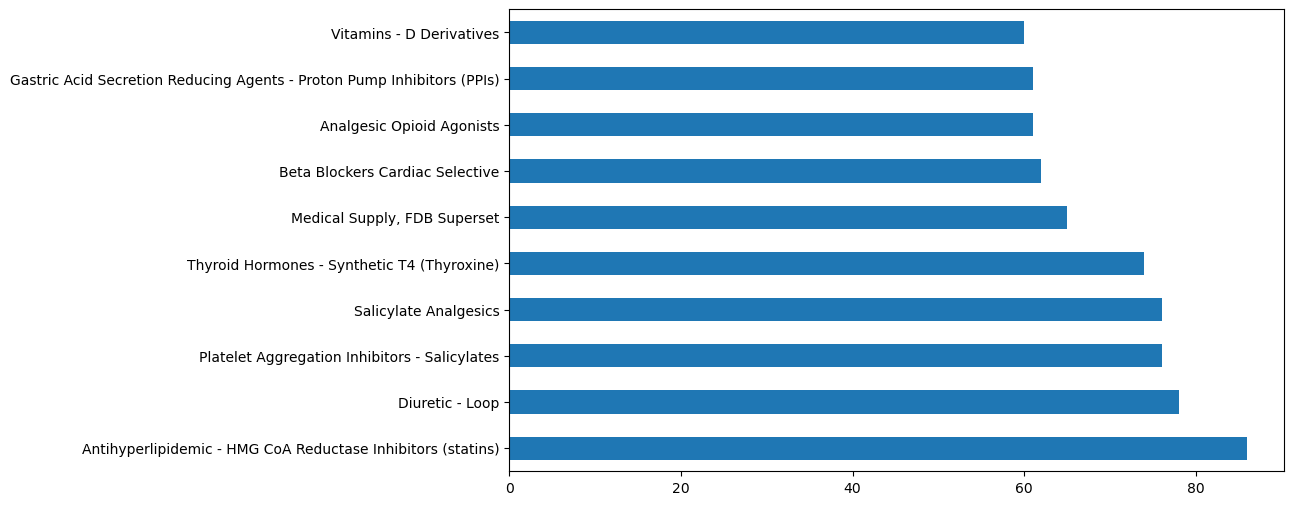

In [19]:
medrecon_df['etcdescription'].value_counts().head(10).plot(kind='barh', figsize=(10, 6));

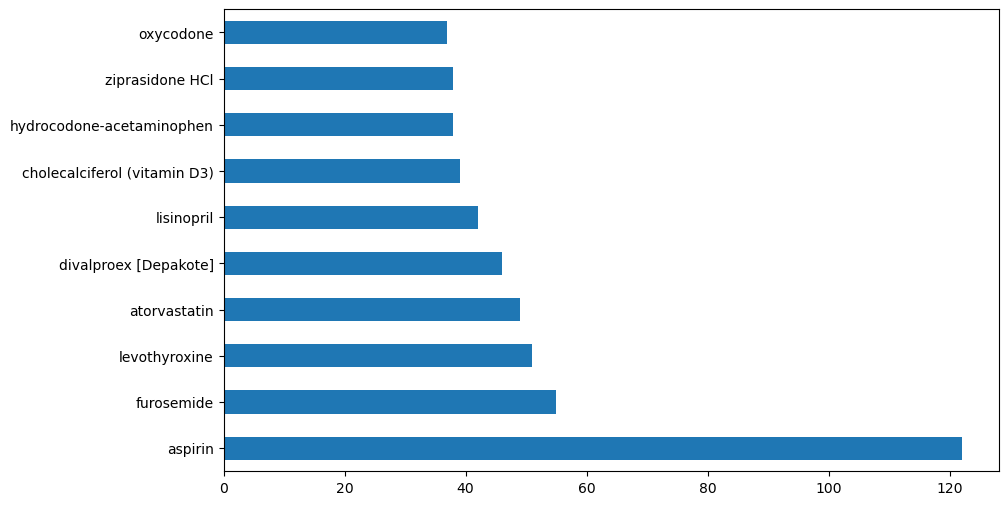

In [20]:
medrecon_df['name'].value_counts().head(10).plot(kind='barh', figsize=(10, 6));

In [21]:
medrecon_columns = ['subject_id', 'stay_id', 'name', 'gsn', 'ndc', 'etc_rn', 'etccode', 'etcdescription']

In [22]:
medrecon_df = preprocess_data(medrecon_df, medrecon_columns)

Null values removed: 8, Duplicates removed: 4


### 4- pyxis

In [23]:
pyxis_path = os.path.join(RAW_DATA_PATH, "pyxis.csv")
pyxis_df = pd.read_csv(pyxis_path)

| Column          | What it means (in plain language)                                                      |
| --------------- | -------------------------------------------------------------------------------------- |
| **subject\_id** | The unique ID of the patient.                                                          |
| **stay\_id**    | The ID of the hospital/ED stay when the medication was dispensed.                      |
| **charttime**   | The exact date and time the medication was given from the Pyxis machine.               |
| **med\_rn**     | A row number used to separate different medications given at the same time.            |
| **name**        | The name of the medication dispensed (can include form, like "tablet" or "injection"). |
| **gsn**         | Generic Sequence Number – a code for the drug’s generic identity (0 if missing).       |
| **gsn\_rn**     | A row number used when there are multiple GSNs for the same medication.                |


In [24]:
pyxis_df.head()

,subject_id,stay_id,charttime,med_rn,name,gsn_rn,gsn
0,10012853,36185653,2175-04-05 06:39:00,4,Aspirin,1,4380.0
1,10040025,37401157,2145-10-19 23:53:00,2,Aspirin,1,4380.0
2,10014354,30279522,2149-09-17 11:51:00,2,Aspirin,1,4380.0
3,10040025,30836087,2145-07-04 10:27:00,10,Aspirin,1,4380.0
4,10032725,30701739,2143-03-22 21:48:00,2,Aspirin,1,4376.0


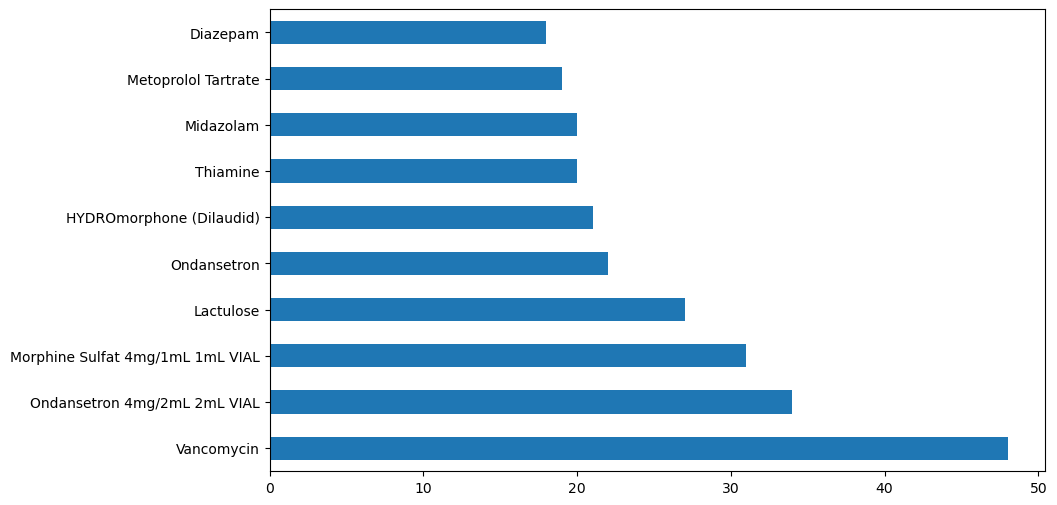

In [25]:
pyxis_df['name'].value_counts().head(10).plot(kind='barh', figsize=(10, 6));

In [26]:
pyxis_columns = ['subject_id', 'stay_id', 'med_rn', 'name', 'gsn_rn','gsn']

In [27]:
pyxis_df = preprocess_data(pyxis_df, pyxis_columns)

Null values removed: 32, Duplicates removed: 0


### 5- triage (SELECTED)

| Column           | Description                                                              |
| ---------------- | ------------------------------------------------------------------------ |
| `subject_id`     | Unique identifier for the patient.                                       |
| `stay_id`        | Unique identifier for the ED stay.                                       |
| `temperature`    | Body temperature at triage (in **Fahrenheit**).                          |
| `heartrate`      | Heart rate (beats per minute) at triage.                                 |
| `resprate`       | Respiratory rate (breaths per minute) at triage.                         |
| `o2sat`          | Oxygen saturation (%) at triage.                                         |
| `sbp`            | Systolic blood pressure (mmHg) at triage.                                |
| `dbp`            | Diastolic blood pressure (mmHg) at triage.                               |
| `pain`           | Self-reported pain score (usually on a scale from 0–10).                 |
| `acuity`         | Acuity level (1 = highest severity, 5 = lowest).                         |
| `chiefcomplaint` | Free-text reason for ED visit, may be comma-separated and de-identified. |


**1. EDA**

In [28]:
triage_path = os.path.join(RAW_DATA_PATH, "triage.csv")
triage_df = pd.read_csv(triage_path)
triage_df.head()

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10016742,33211001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PICC EVAL
1,10032725,30701739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACIAL DROOP
2,10010867,30115213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MVC/INTUBATED TRAUMA
3,10004235,38926302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S/P ARREST
4,10027602,36678718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEAD BLEED


In [29]:
triage_df.describe()

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity
count,2.220000e+02,2.220000e+02,196.000000,198.000000,199.000000,198.000000,199.000000,199.000000,207.000000
mean,1.001960e+07,3.533334e+07,97.785714,91.171717,18.135678,97.691919,136.949749,77.040201,2.367150
std,1.226325e+04,2.996074e+06,4.484172,18.894062,3.007849,2.700072,27.830248,59.266121,0.653952
min,1.000003e+07,3.009412e+07,36.500000,43.000000,14.000000,78.000000,70.000000,42.000000,1.000000
25%,1.001285e+07,3.254778e+07,97.600000,77.000000,16.000000,97.000000,116.500000,62.000000,2.000000
50%,1.001715e+07,3.546143e+07,98.100000,89.500000,18.000000,98.000000,136.000000,72.000000,2.000000
75%,1.002633e+07,3.810308e+07,98.500000,104.000000,18.000000,100.000000,154.500000,82.500000,3.000000
max,1.004002e+07,3.996872e+07,100.300000,157.000000,32.000000,100.000000,218.000000,879.000000,4.000000


In [30]:
triage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      222 non-null    int64  
 1   stay_id         222 non-null    int64  
 2   temperature     196 non-null    float64
 3   heartrate       198 non-null    float64
 4   resprate        199 non-null    float64
 5   o2sat           198 non-null    float64
 6   sbp             199 non-null    float64
 7   dbp             199 non-null    float64
 8   pain            201 non-null    object 
 9   acuity          207 non-null    float64
 10  chiefcomplaint  222 non-null    object 
dtypes: float64(7), int64(2), object(2)
memory usage: 19.2+ KB


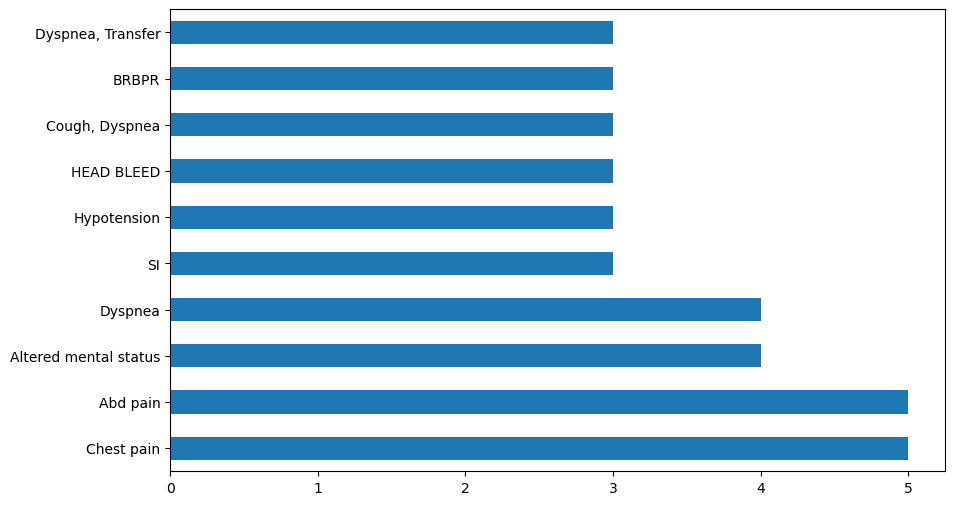

In [31]:
triage_df['chiefcomplaint'].value_counts().head(10).plot(kind='barh', figsize=(10, 6));

**2. Data Cleaning**

In [33]:
def clean_pain(value):
    try:
        val = int(value)
        if 0 <= val <= 10:
            return val
    except:
        pass
    return np.nan  

# 0–10 scale, where 0 is no pain and 10 is worst imaginable pain.
triage_df['pain'] = triage_df['pain'].apply(clean_pain)

In [34]:
# from Fahrenheit to Celsius
triage_df["temperature"] = ((triage_df["temperature"] - 32) * 5/9).round(1)
triage_df["temperature"].describe()

# Human body temperature (hypothermia threshold, hyperthermia threshold)
triage_df = triage_df[triage_df['temperature'].between(27.0, 43.0)]
triage_df.shape

(195, 11)

In [35]:
# Select relevant columns for triage data
triage_columns = ['subject_id','stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint']

In [36]:
# Removing nulls and duplicates from the triage data
triage_df = preprocess_data(triage_df, triage_columns)

Null values removed: 19, Duplicates removed: 0


### 6- vitalsign (SELECTED)

**1. EDA**

In [37]:
vitalsign_path = os.path.join(RAW_DATA_PATH, "vitalsign.csv")
vitalsign_df = pd.read_csv(vitalsign_path)
vitalsign_df.head()

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10014729,37887480,2125-03-19 13:22:00,NaN,124.0,24.0,100.0,93.0,65.0,NaN,NaN
1,10014729,37887480,2125-03-19 18:28:00,98.9,106.0,18.0,100.0,115.0,70.0,Sinus Tachycardia,5
2,10014729,37887480,2125-03-19 13:07:00,NaN,128.0,18.0,100.0,132.0,96.0,Sinus Tachycardia,NaN
3,10014729,37887480,2125-03-19 16:23:00,99.8,115.0,22.0,97.0,114.0,45.0,Sinus Tachycardia,0
4,10014729,37887480,2125-03-19 13:24:00,NaN,125.0,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
vitalsign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   subject_id   1038 non-null   int64  
 1   stay_id      1038 non-null   int64  
 2   charttime    1038 non-null   object 
 3   temperature  579 non-null    float64
 4   heartrate    1008 non-null   float64
 5   resprate     990 non-null    float64
 6   o2sat        971 non-null    float64
 7   sbp          998 non-null    float64
 8   dbp          998 non-null    float64
 9   rhythm       33 non-null     object 
 10  pain         736 non-null    object 
dtypes: float64(6), int64(2), object(3)
memory usage: 89.3+ KB


In [39]:
vitalsign_df['pain'].unique()

array([nan, '5', '0', '7', '8', '1', '2', '3', 'unable', '4', 'asleep',
       'Critical', '9', '10', '6', 'sleeping', 'sleepin', 'sleep ',
       'laying down', 'standing ', 'sitting ', 'UA', '8.5', 'uta', 'u',
       'denies', 'does not scale', 'grimace with palpation', 'Unable',
       'sedated', 'uncooperative', 'NAD', 'UTA', '0/10', 'intubated',
       'ett', 'Asleep', 'sleep', 'ua'], dtype=object)

**2. Data Cleaning**

In [40]:
vitalsign_df['pain'] = vitalsign_df['pain'].apply(clean_pain)
vitalsign_df['temperature'] = ((vitalsign_df['temperature'] - 32) * 5/9).round(1)

In [41]:
# Null values that have less than 50% missing data
null_columns = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain']

for col in null_columns:
    skewness = vitalsign_df[col].skew()
    if abs(skewness) < 0.5:
        # almost symmetric
        fill_value = vitalsign_df[col].mean()
    else:
        # skewed distribution
        fill_value = vitalsign_df[col].median()
    vitalsign_df[col].fillna(fill_value, inplace=True)

In [42]:
vitalsign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   subject_id   1038 non-null   int64  
 1   stay_id      1038 non-null   int64  
 2   charttime    1038 non-null   object 
 3   temperature  1038 non-null   float64
 4   heartrate    1038 non-null   float64
 5   resprate     1038 non-null   float64
 6   o2sat        1038 non-null   float64
 7   sbp          1038 non-null   float64
 8   dbp          1038 non-null   float64
 9   rhythm       33 non-null     object 
 10  pain         1038 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 89.3+ KB


`rhythm` column has very high number of nulls. so, it will be dropped.

In [43]:
vitalsign_columns = ['subject_id', 'temperature', 'stay_id', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain']
vitalsign_df = preprocess_data(vitalsign_df, vitalsign_columns)

Null values removed: 0, Duplicates removed: 2


We have two temperatures 
- triage_df = snapshot at arrival
- vitalsign_df = multiple measurements during stay

I dropped time variables since We are not using temporal features.

### Merging

- Three tables (`triage`, `edstays`, and `vitalsign`) are chosen only which contained core clinical indicators of patient status.
- They are joined using inner join. Inner join is used to select records that have matching values of `subject_id` and `stay_id` in all tables.

In [44]:
KEYS = ["subject_id", "stay_id"]

triage_df    = triage_df.rename(columns=lambda c: c if c in KEYS else f"{c}_triage")
edstays_df   = edstays_df.rename(columns=lambda c: c if c in KEYS else f"{c}_edstays")
vitalsign_df = vitalsign_df.rename(columns=lambda c: c if c in KEYS else f"{c}_vitalsign")

joined_df = (
    triage_df
    .merge(edstays_df,   on=KEYS, how="inner")
    .merge(vitalsign_df, on=KEYS, how="inner")
)
joined_df.shape

(799, 22)

In [45]:
joined_df.isna().sum()

subject_id                   0
stay_id                      0
temperature_triage           0
heartrate_triage             0
resprate_triage              0
o2sat_triage                 0
sbp_triage                   0
dbp_triage                   0
pain_triage                  0
acuity_triage                0
chiefcomplaint_triage        0
gender_edstays               0
race_edstays                 0
arrival_transport_edstays    0
disposition_edstays          0
temperature_vitalsign        0
heartrate_vitalsign          0
resprate_vitalsign           0
o2sat_vitalsign              0
sbp_vitalsign                0
dbp_vitalsign                0
pain_vitalsign               0
dtype: int64

In [46]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 798
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subject_id                 799 non-null    int64  
 1   stay_id                    799 non-null    int64  
 2   temperature_triage         799 non-null    float64
 3   heartrate_triage           799 non-null    float64
 4   resprate_triage            799 non-null    float64
 5   o2sat_triage               799 non-null    float64
 6   sbp_triage                 799 non-null    float64
 7   dbp_triage                 799 non-null    float64
 8   pain_triage                799 non-null    float64
 9   acuity_triage              799 non-null    float64
 10  chiefcomplaint_triage      799 non-null    object 
 11  gender_edstays             799 non-null    object 
 12  race_edstays               799 non-null    object 
 13  arrival_transport_edstays  799 non-null    object 

In [48]:
joined_df.describe()

,subject_id,stay_id,temperature_triage,heartrate_triage,resprate_triage,o2sat_triage,sbp_triage,dbp_triage,pain_triage,acuity_triage,temperature_vitalsign,heartrate_vitalsign,resprate_vitalsign,o2sat_vitalsign,sbp_vitalsign,dbp_vitalsign,pain_vitalsign
count,7.990000e+02,7.990000e+02,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,1.001905e+07,3.529977e+07,36.745056,90.351690,17.891114,97.718398,136.031289,72.931164,4.299124,2.382979,36.593992,86.078849,18.040050,97.745932,128.703846,69.339416,2.110138
std,1.152670e+04,3.051895e+06,0.459456,18.965679,2.527425,2.484952,26.095310,16.649310,3.940267,0.584692,2.519356,18.766806,3.172706,3.686904,22.742029,14.608742,3.295457
min,1.000003e+07,3.009412e+07,35.700000,43.000000,14.000000,78.000000,70.000000,42.000000,0.000000,1.000000,1.200000,48.000000,8.000000,10.000000,65.000000,32.000000,0.000000
25%,1.001435e+07,3.228780e+07,36.500000,76.000000,16.000000,97.000000,119.000000,63.000000,0.000000,2.000000,36.700000,72.000000,16.000000,97.000000,115.000000,59.000000,0.000000
50%,1.001593e+07,3.545264e+07,36.700000,90.000000,18.000000,98.000000,137.000000,71.000000,5.000000,2.000000,36.700000,84.000000,18.000000,98.000000,126.943888,69.000000,0.000000
75%,1.002324e+07,3.813399e+07,36.900000,105.000000,18.000000,99.000000,153.000000,82.000000,8.000000,3.000000,36.800000,98.500000,19.000000,99.000000,143.000000,80.000000,5.000000
max,1.004002e+07,3.996872e+07,37.900000,140.000000,28.000000,100.000000,218.000000,118.000000,10.000000,4.000000,40.500000,150.000000,34.000000,100.000000,200.000000,117.000000,10.000000


| Column                      | Description                                                             | Source Table |
| --------------------------- | ----------------------------------------------------------------------- | ------------ |
| `temperature_triage`        | Body temperature at ED triage (numeric only)                            | `triage`     |
| `heartrate_triage`          | Heart rate at ED triage                                                 | `triage`     |
| `resprate_triage`           | Respiratory rate at ED triage                                           | `triage`     |
| `o2sat_triage`              | Oxygen saturation at ED triage                                          | `triage`     |
| `sbp_triage`                | Systolic blood pressure at ED triage                                    | `triage`     |
| `dbp_triage`                | Diastolic blood pressure at ED triage                                   | `triage`     |
| `pain_triage`               | Patient self-reported pain level at triage (0 = none, 10 = worst)       | `triage`     |
| `acuity_triage`             | Triage-assigned acuity level (1 = most severe, 5 = least severe)        | `triage`     |
| `chiefcomplaint_triage`     | Free-text reason for ED visit, comma-separated, PHI replaced with `___` | `triage`     |
| `gender_edstays`            | Patient’s gender as recorded during ED stay                             | `edstays`    |
| `race_edstays`              | Patient’s race as recorded during ED stay                               | `edstays`    |
| `arrival_transport_edstays` | Mode of transport to ED (e.g., ambulance, walk-in)                      | `edstays`    |
| `disposition_edstays`       | Outcome of the ED stay (e.g., discharge, admitted)                      | `edstays`    |
| `heartrate_vitalsign`       | Heart rate recorded during ED stay (not necessarily at triage)          | `vitalsign`  |
| `resprate_vitalsign`        | Respiratory rate during ED stay                                         | `vitalsign`  |
| `o2sat_vitalsign`           | Oxygen saturation during ED stay                                        | `vitalsign`  |
| `sbp_vitalsign`             | Systolic blood pressure during ED stay                                  | `vitalsign`  |
| `dbp_vitalsign`             | Diastolic blood pressure during ED stay                                 | `vitalsign`  |
| `pain_vitalsign`            | Pain level during ED stay (not necessarily at triage)                   | `vitalsign`  |


### EDA of joined tables

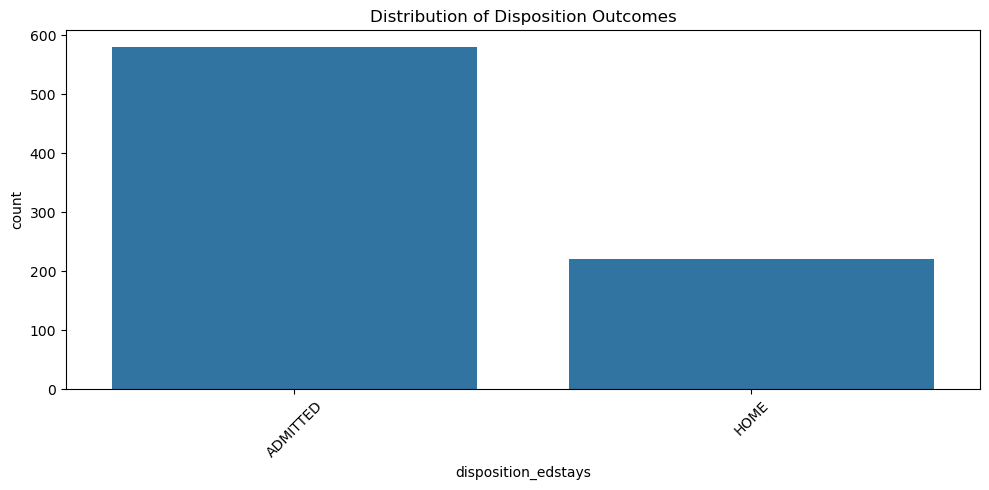

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(x="disposition_edstays", data=joined_df,
              order=joined_df["disposition_edstays"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Disposition Outcomes")
plt.tight_layout()
plt.show()


C:\Users\ahmed\AppData\Local\Temp\ipykernel_1692\443163091.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="disposition_edstays", y="heartrate_vitalsign",


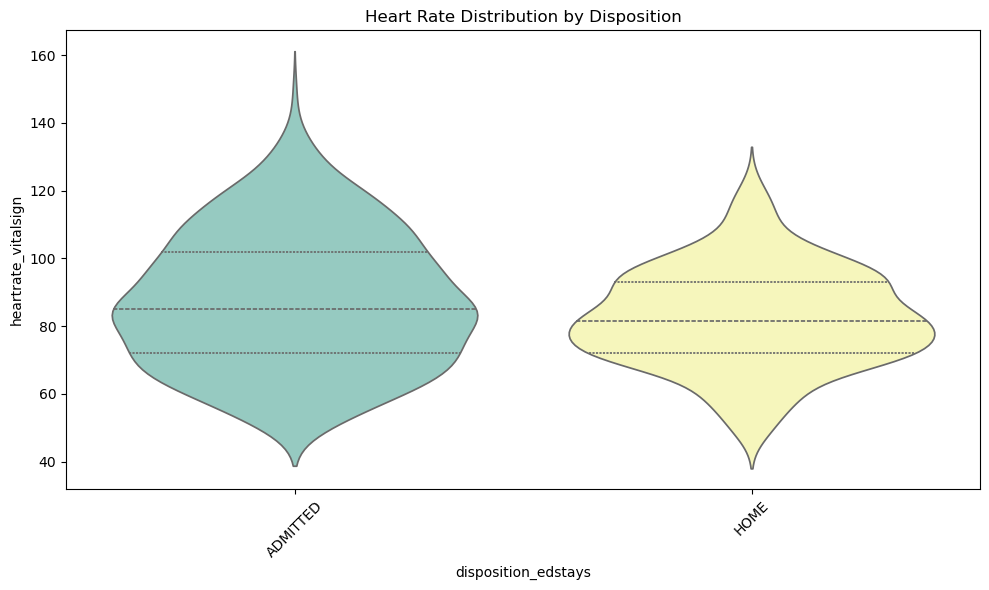

In [81]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="disposition_edstays", y="heartrate_vitalsign",
               data=joined_df, inner="quartile", palette="Set3")
plt.xticks(rotation=45)
plt.title("Heart Rate Distribution by Disposition")
plt.tight_layout()
plt.show()


C:\Users\ahmed\AppData\Local\Temp\ipykernel_1692\2330336856.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x="acuity_triage", col="disposition_edstays",


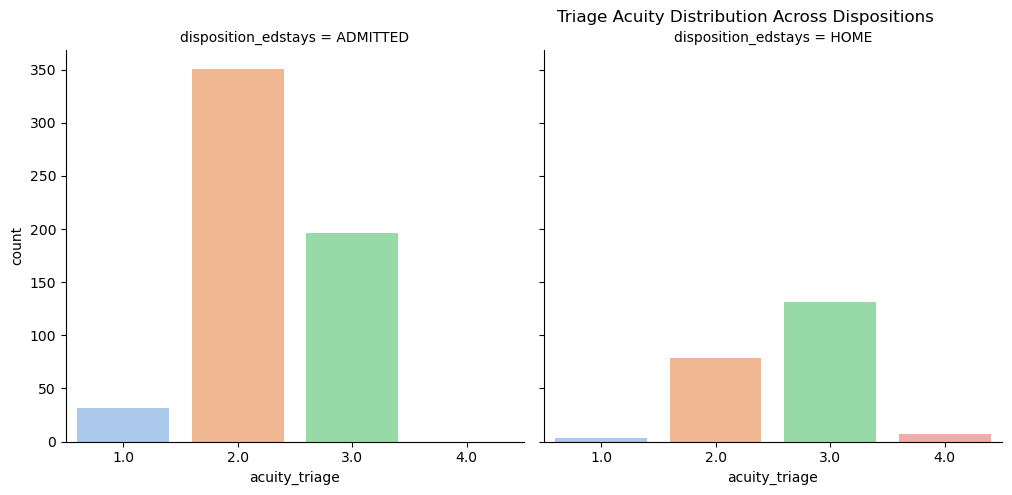

In [84]:
sns.catplot(x="acuity_triage", col="disposition_edstays",
            kind="count", col_wrap=3, data=joined_df,
            order=sorted(joined_df["acuity_triage"].unique()), palette="pastel")
plt.subplots_adjust(top=0.9)
plt.suptitle("Triage Acuity Distribution Across Dispositions")
plt.show()


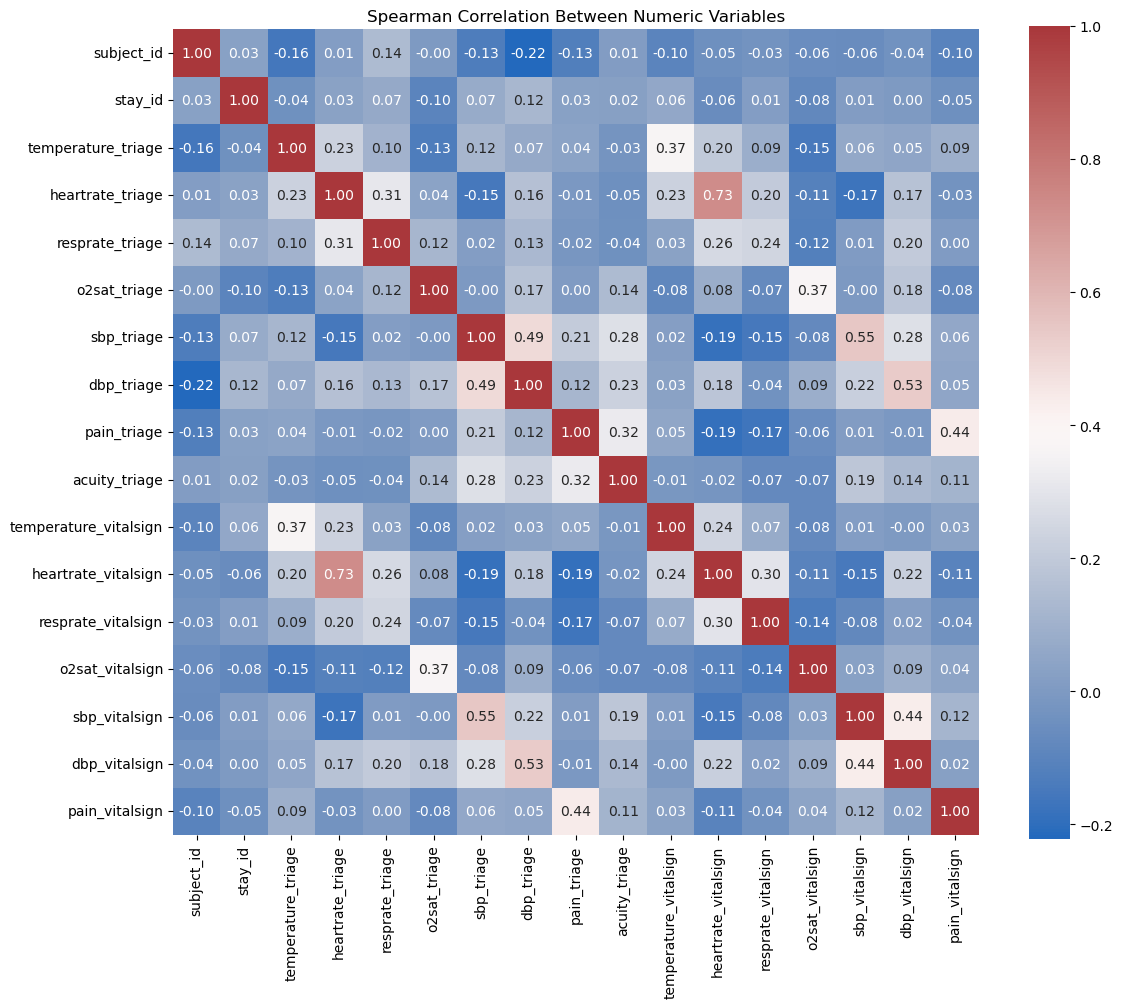

In [85]:
import numpy as np

numeric_cols = joined_df.select_dtypes(include=np.number)
corr = numeric_cols.corr(method="spearman")

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="vlag", annot=True, fmt=".2f", square=True)
plt.title("Spearman Correlation Between Numeric Variables")
plt.tight_layout()
plt.show()


### Data Encoding

In [49]:
ordinal_enc_cols = []
ohe_enc_cols= []
qualitative_cols = joined_df.select_dtypes(include=['object']).columns

for col in qualitative_cols:
    if joined_df[col].nunique() < 10:
        ohe_enc_cols.append(col)
    else:
        ordinal_enc_cols.append(col)
print(f"Ordinal Encoding Columns: {ordinal_enc_cols}")
print(f"One-Hot Encoding Columns: {ohe_enc_cols}")

Ordinal Encoding Columns: ['chiefcomplaint_triage']
One-Hot Encoding Columns: ['gender_edstays', 'race_edstays', 'arrival_transport_edstays', 'disposition_edstays']


In [50]:
encoded_df = joined_df.copy(deep=True)
ord_enc = OrdinalEncoder()

encoded_df[ordinal_enc_cols] = ord_enc.fit_transform(encoded_df[ordinal_enc_cols])
encoded_df[ordinal_enc_cols] = encoded_df[ordinal_enc_cols].replace(-1, np.nan)
encoded_df = pd.get_dummies(encoded_df, columns=ohe_enc_cols, drop_first=False, dtype="int8")

encoded_df.head()

,subject_id,stay_id,temperature_triage,heartrate_triage,resprate_triage,o2sat_triage,sbp_triage,dbp_triage,pain_triage,acuity_triage,...,race_edstays_OTHER,race_edstays_PORTUGUESE,race_edstays_WHITE,race_edstays_WHITE - BRAZILIAN,arrival_transport_edstays_AMBULANCE,arrival_transport_edstays_OTHER,arrival_transport_edstays_UNKNOWN,arrival_transport_edstays_WALK IN,disposition_edstays_ADMITTED,disposition_edstays_HOME
0,10023239,39348852,36.6,115.0,20.0,99.0,92.0,42.0,0.0,2.0,...,0,0,1,0,1,0,0,0,1,0
1,10023239,39348852,36.6,115.0,20.0,99.0,92.0,42.0,0.0,2.0,...,0,0,1,0,1,0,0,0,1,0
2,10014354,39621946,36.8,57.0,18.0,99.0,161.0,68.0,0.0,2.0,...,0,0,1,0,1,0,0,0,1,0
3,10014354,39621946,36.8,57.0,18.0,99.0,161.0,68.0,0.0,2.0,...,0,0,1,0,1,0,0,0,1,0
4,10014354,39621946,36.8,57.0,18.0,99.0,161.0,68.0,0.0,2.0,...,0,0,1,0,1,0,0,0,1,0


In [51]:
encoded_df.columns

Index(['subject_id', 'stay_id', 'temperature_triage', 'heartrate_triage',
       'resprate_triage', 'o2sat_triage', 'sbp_triage', 'dbp_triage',
       'pain_triage', 'acuity_triage', 'chiefcomplaint_triage',
       'temperature_vitalsign', 'heartrate_vitalsign', 'resprate_vitalsign',
       'o2sat_vitalsign', 'sbp_vitalsign', 'dbp_vitalsign', 'pain_vitalsign',
       'gender_edstays_F', 'gender_edstays_M',
       'race_edstays_BLACK/AFRICAN AMERICAN',
       'race_edstays_HISPANIC/LATINO - CUBAN',
       'race_edstays_HISPANIC/LATINO - SALVADORAN', 'race_edstays_OTHER',
       'race_edstays_PORTUGUESE', 'race_edstays_WHITE',
       'race_edstays_WHITE - BRAZILIAN', 'arrival_transport_edstays_AMBULANCE',
       'arrival_transport_edstays_OTHER', 'arrival_transport_edstays_UNKNOWN',
       'arrival_transport_edstays_WALK IN', 'disposition_edstays_ADMITTED',
       'disposition_edstays_HOME'],
      dtype='object')

### Modeling

`subject_id` and `stay_id` columns exists, We'll need them to avoid data leakage

In [ ]:
from sklearn.model_selection import train_test_split

unique_values = set(encoded_df['stay_id'])

unique_values = list(unique_values)
train_vals, temp_vals = train_test_split(unique_values, test_size=0.3, random_state=42)
val_vals, test_vals = train_test_split(temp_vals, test_size=0.5, random_state=42)

train_df = encoded_df[encoded_df['stay_id'].isin(train_vals)]
val_df = encoded_df[ encoded_df['stay_id'].isin(val_vals)]
test_df = encoded_df[encoded_df['stay_id'].isin(test_vals)]

train_df.shape, val_df.shape, test_df.shape

((576, 33), (112, 33), (111, 33))

In [69]:
common_all = set(train_vals).intersection(val_vals, test_vals)
if common_all:
	print("There are common samples across Train, Val, Test. Please check the data splitting logic.")
else:
    print("No common samples found across Train, Val, Test. Proceeding with saving the data.")


No common samples found across Train, Val, Test. Proceeding with saving the data.


In [ ]:
def get_x_y(df):
	X = df.drop(columns=['subject_id', 'stay_id', 'disposition_edstays_ADMITTED', 'disposition_edstays_HOME'])
	y = df['disposition_edstays_ADMITTED']
	return X, y

In [75]:
X_train, y_train = get_x_y(train_df)
X_val, y_val = get_x_y(val_df)
X_test, y_test = get_x_y(test_df)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}"
      f"\nX_val shape: {X_val.shape}, y_val shape: {y_val.shape}"
	  f"\nX_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (576, 31), y_train shape: (576,)
X_val shape: (112, 31), y_val shape: (112,)
X_test shape: (111, 31), y_test shape: (111,)
